In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv

In [5]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

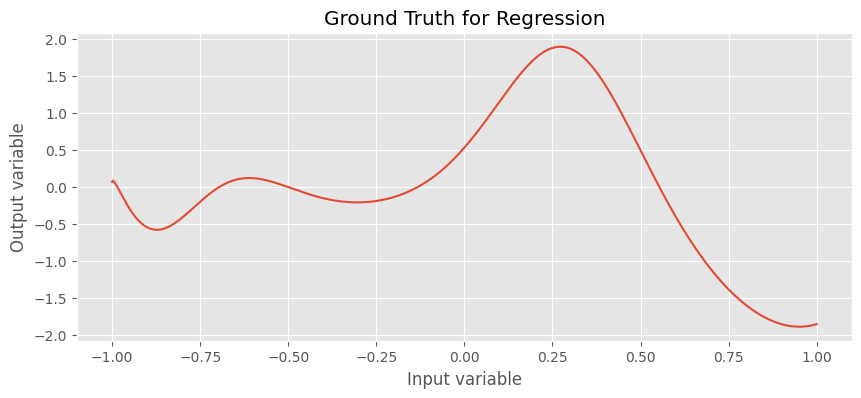

In [6]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

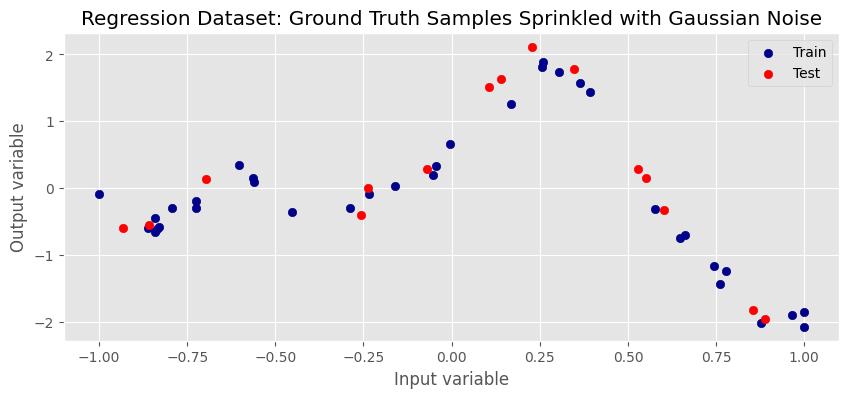

In [7]:
def generate_dataset(size=50, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [139]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, df, init_var=1e-3, prior_var = 1 ):
        super(MeanFieldLayer, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.df         = df

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.StudentT(self.df, self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.StudentT(self.df, self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.StudentT(self.df, self.w_mu_q, torch.exp(0.5 * self.w_log_var_q))

    def q_b(self):
        """variational bias posterior"""#
        return torch.distributions.StudentT(self.df, self.b_mu_q, torch.exp(0.5 * self.b_log_var_q))

    
    def kl(self, num_samples = 10):
        weight_samples = self.q_w().rsample((num_samples,))  # rsample allows for gradient propagation
        bias_samples = self.q_b().rsample((num_samples,))

        log_q_w = self.q_w().log_prob(weight_samples)  
        log_p_w = self.p_w().log_prob(weight_samples)

        log_q_b = self.q_b().log_prob(bias_samples)
        log_p_b = self.p_b().log_prob(bias_samples)

        weight_kl = (log_q_w - log_p_w).mean()  # Average over samples
        bias_kl = (log_q_b - log_p_b).mean()
        return weight_kl + bias_kl
        

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).


        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases # (num_samples, batch_size, output_dim).








class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        df = 10,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1.0,
        catagorical = False
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim     = input_dim
        self.hidden_dims   = hidden_dims
        self.output_dim    = output_dim
        self.activation    = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        self.df            = df
        self.catagorical   = catagorical

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], self.df, prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, self.df, prior_var = prior_var)
                )
                
                if (catagorical):
                    self.network.append(torch.nn.Softmax(dim=2))
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], self.df, prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim
        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        if (self.catagorical):
            l = torch.distributions.Categorical(probs=y_pred)
            y_obs = y_obs.unsqueeze(0).expand(y_pred.shape)
            print(y_obs.size(), y_pred.size())
        else:
            l = torch.distributions.StudentT(self.df, y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    def kl(self, num_samples = 10):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(num_samples = num_samples) for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=10):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        #print(y, y_pred, num_samples)
        exp_ll = self.ll(y, y_pred)
        kl = self.kl(num_samples = num_samples)

        return kl - exp_ll, exp_ll, kl

In [37]:

# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
def model_train(bnn_model, x_tr, x_te, y_tr, y_te, num_epoch, error_type = nn.MSELoss()):

    opt = torch.optim.Adam(
        bnn_model.parameters(),
        lr = 1e-2
    )

    tr_loss_evo = []
    tr_ll_evo = []
    tr_kl_evo = []
    te_loss_evo = []

    tr_loss_evo = []
    te_loss_evo = []
    aux_loss = error_type



    for epoch in tqdm(range(num_epoch)):  # epochs
        opt.zero_grad()

        l, ll, kl = bnn_model.loss(x_tr, y_tr)
        
        tr_loss_evo.append(l.item())
        tr_ll_evo.append(ll.item())
        tr_kl_evo.append(kl.item())
       # print(bnn_model(x_tr).mean(0), y_tr.unsqueeze(0))
       # print(tr_loss_evo)
       # print(aux_loss(bnn_model(x_tr).mean(0), y_tr.unsqueeze(0)).item())
        tr_loss_evo.append(aux_loss(bnn_model(x_tr).mean(0), y_tr.unsqueeze(0)).item()) 

        te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
        te_loss_evo.append(aux_loss(bnn_model(x_te).mean(0), y_te.unsqueeze(0)).item()) 

        l.backward()
        opt.step()

    plt.rcParams["figure.figsize"] = (10, 4)

    plt.plot(tr_loss_evo, label='Train dataset loss')
    plt.plot(te_loss_evo, label='Test dataset loss')
    plt.ylabel('ELBO loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Loss Evolution')
    plt.show()

    plt.plot(tr_ll_evo, label='Train dataset log-like evo')
    plt.ylabel('expected log likelihood')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Expected Log Likelihood Evolution')
    plt.show()

    plt.plot(tr_kl_evo, label='Train dataset kl evo')
    plt.ylabel('kl')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('KL Evolution')
    plt.show()

    plt.plot(tr_loss_evo, label='Train dataset')
    plt.plot(te_loss_evo, label='Test dataset')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('MSE Evolution')
    plt.show()

    return bnn_model 



  0%|          | 0/4000 [00:00<?, ?it/s]

c:\Users\james\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 35, 1])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\james\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 15, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4000/4000 [03:55<00:00, 16.96it/s]


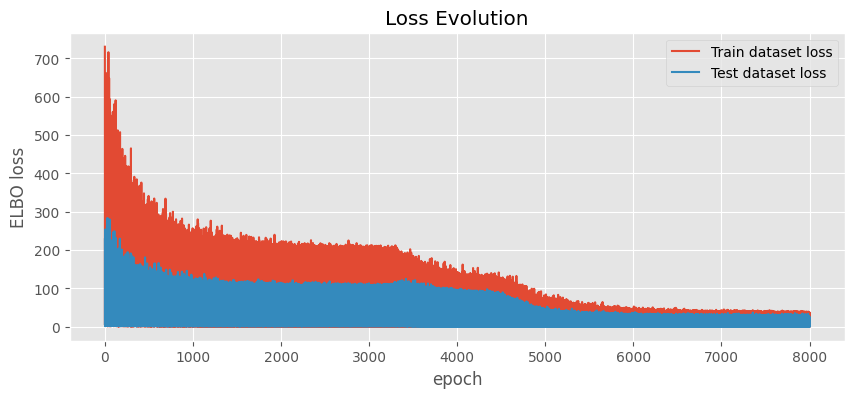

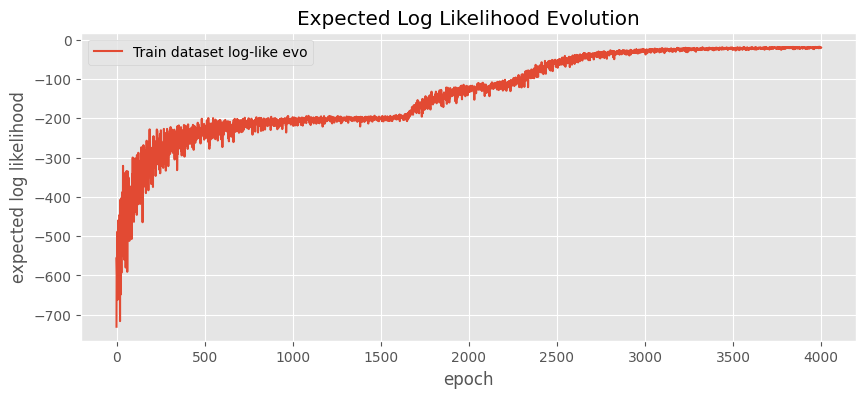

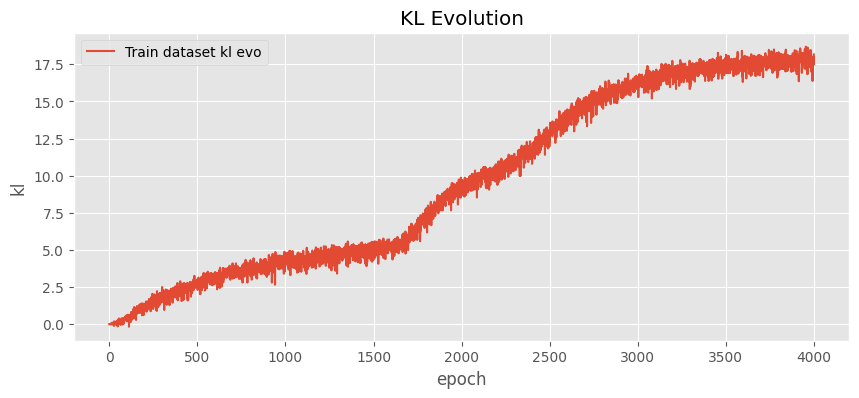

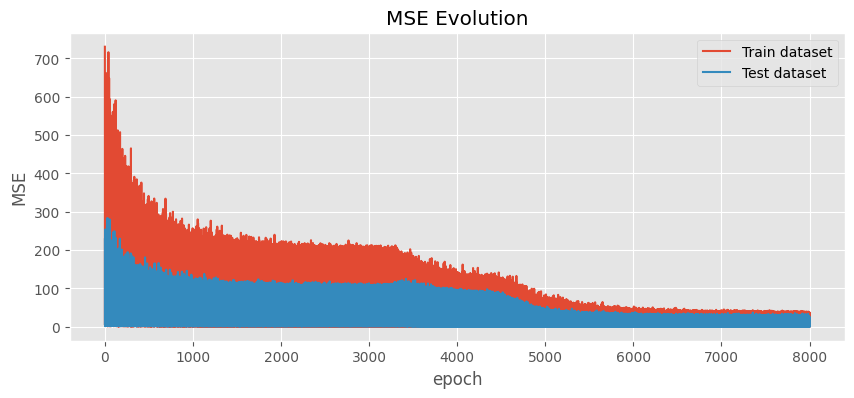

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
  )
)

In [138]:
bnn_model = MeanFieldBNN(1, [4, 4], 1, noise_std=0.15, df = 10)
model_train(bnn_model, x_tr, x_te, y_tr, y_te, 4000)

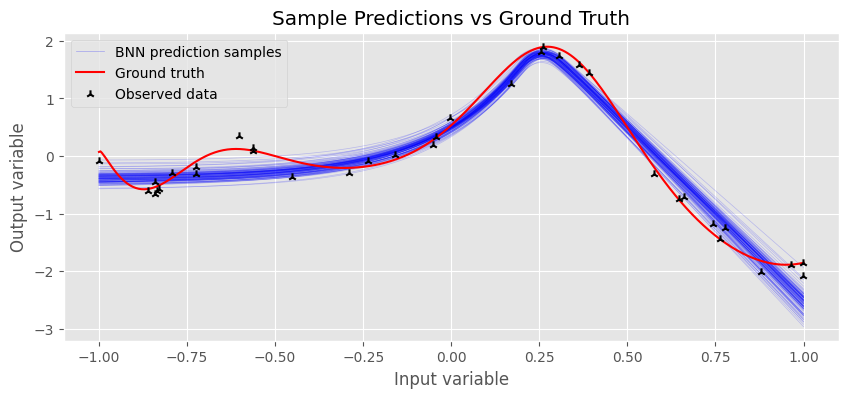

In [11]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

### Laplace distridution

In [123]:
class MeanFieldLayer_lap(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3, prior_var = 1 ):
        super(MeanFieldLayer_lap, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        # self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        # self.b_log_var_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Laplace(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Laplace(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Laplace(self.w_mu_q, torch.exp(0.5 * self.w_log_var_q))

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Laplace(self.b_mu_q, torch.exp(0.5 * self.b_log_var_q))

    
    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum()
        bias_kl   = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return torch.sum(weight_kl + bias_kl)
        

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."

        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        
        return x @ weights + biases

class MeanFieldBNN_lap(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1.0,
        catagorical = False
    ):
        super(MeanFieldBNN_lap, self).__init__()
        self.input_dim     = input_dim
        self.hidden_dims   = hidden_dims
        self.output_dim    = output_dim
        self.activation    = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        self.catagorical   = catagorical 

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer_lap(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer_lap(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
                if (catagorical):
                    self.network.append(torch.nn.Softmax(dim=2))
            else:
                self.network.append(
                    MeanFieldLayer_lap(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        if (self.catagorical):
            l = torch.distributions.Categorical(probs=y_pred)
        else:
            l = torch.distributions.normal.Normal( y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer_lap)])

    def loss(self, x, y, num_samples=10):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x)#, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred)
        kl     = self.kl()
        return kl - exp_ll, exp_ll, kl

100%|██████████| 4000/4000 [02:54<00:00, 22.90it/s]


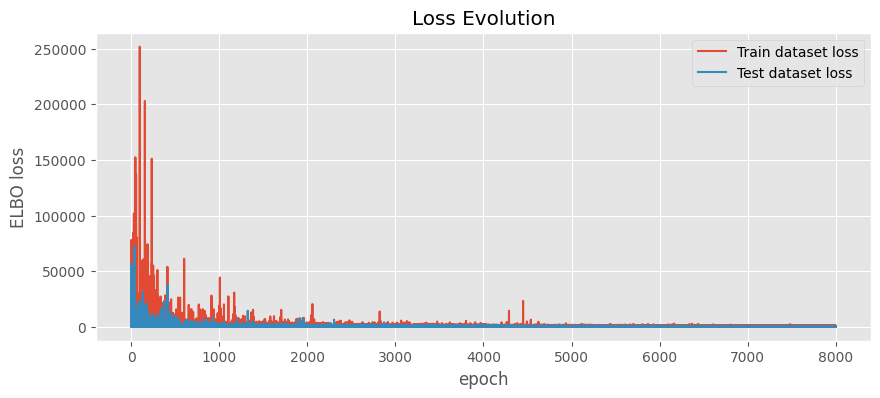

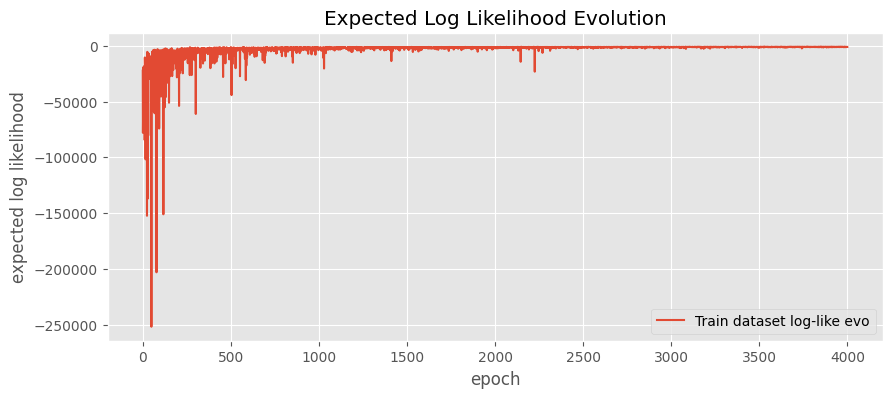

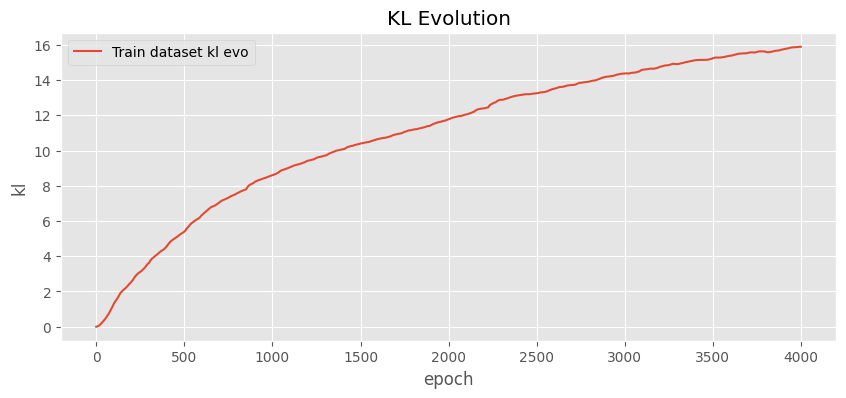

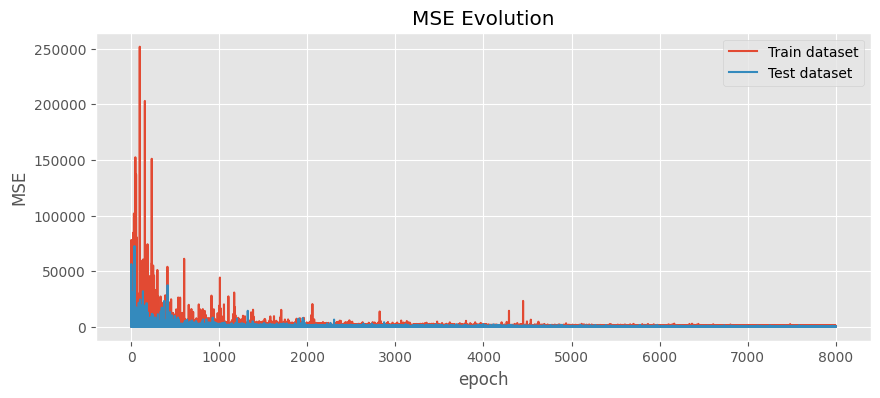

MeanFieldBNN_lap(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer_lap()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer_lap()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer_lap()
  )
)

In [15]:
bnn_model_lap = MeanFieldBNN_lap(1, [4, 4], 1, noise_std=0.15, catagorical = False)

model_train(bnn_model_lap, x_tr, x_te, y_tr, y_te, 4000)

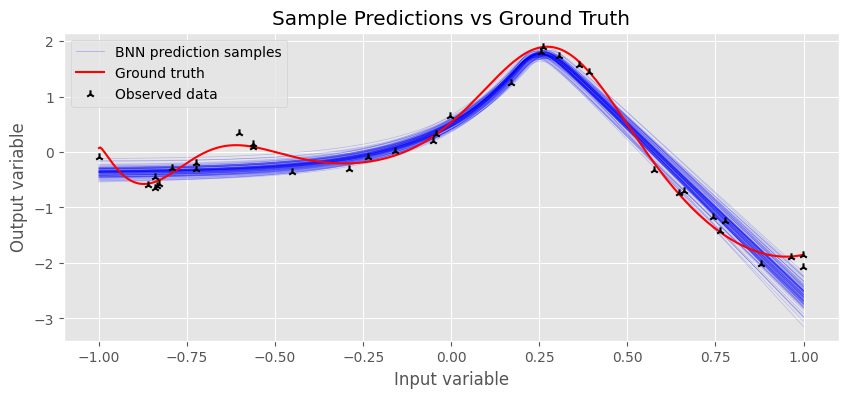

In [17]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

In [144]:
weather = []
with open('seattle-weather.csv', newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        weather = weather + [row]

weather
weather_names = ['year', 'month', 'day'] + weather[0][1:-1]

sea_weather = []
the_weather = []
for alist in weather[1:]:
    element = []

    date = alist[0]
    # year
    element.append(float(date[:4]))
    # month
    element.append(float(date[5:7]))
    # day
    element.append(float(date[8:10]))
    # precipitation
    element.append(float(alist[1]))
    # temp max
    element.append(float(alist[2]))
    # temp min
    element.append(float(alist[3]))
    # wind
    element.append(float(alist[4]))

    sea_weather.append(element)
    
    state = alist[5]
    if 'rain' == state:
        the_weather.append(0)
    elif 'sun' == state:
        the_weather.append(1)
    elif 'fog' == state:
        the_weather.append(2)
    else:
        the_weather.append(3)
 

In [145]:
seattle_tr, seattle_te, weather_tr, weather_te = train_test_split(torch.tensor(sea_weather), torch.tensor(the_weather, dtype = torch.long),
                                                                   test_size = 1/10, random_state = 13)

base      = model_train(MeanFieldBNN(7, [20, 20, 20], 1, noise_std = 0.15, catagorical = True),
                         seattle_tr, seattle_te, weather_tr, weather_te, 4000, error_type=nn.NLLLoss())
bnn_model = model_train(MeanFieldBNN_lap(7, [20, 20, 20], 1, noise_std = 0.15, catagorical = True),
                         seattle_tr, seattle_te, weather_tr, weather_te, 4000, error_type=nn.NLLLoss())
# print(

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (1) must match the existing size (1314) at non-singleton dimension 2.  Target sizes: [10, 1314, 1].  Tensor sizes: [1, 1314]

In [76]:
preds_1   = bnn_model(seattle_te, num_samples=num_samps).squeeze(-1).detach()
S_of_Sq_L = torch.sum((preds_1 - torch.mean(weather_te))**2)
preds_2   = base(seattle_te, num_samples=num_samps).squeeze(-1).detach()
S_of_Sq_T = torch.sum((preds_2 - torch.mean(weather_te))**2)
print(S_of_Sq_L, S_of_Sq_T, S_of_Sq_L - S_of_Sq_T)

AssertionError: 

In [ ]:
weather_te.shape

torch.Size([147])